In [ ]:
# develop-self-sustained-translation-operator.ipynb
#
# Bryan Daniels
# 2023/11/9
#
# Try to get translation of edge without external input
# (starting with code from develop-translation-operator.ipynb)

In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

from laplace_network import laplace_network,find_edge_location

In [2]:
def interactionMatrixFromKernel(discreteKernel,N,normed=True,n_decay=np.inf):
    """
    The kernel is assumed to be zero outside of the range [-N/2,N/2].
    
    discreteKernel       : Should have an odd length <= N.  The kernel is centered on the middle element 
                           (index (len(discreteKernel)-1)/2).
    N                    : The number of neurons (dimension of the output matrix is NxN)
    n_decay              : scale over which interaction strength decays as a function of n
    """
    Nk = len(discreteKernel)
    assert(Nk%2==1) # discreteKernel should have odd length
    assert(Nk <= N) # discreteKernel should have length less than or equal to N
    mat = np.zeros((N,N))
    
    # copy in the appropriate part of the kernel for each row
    for i in range(N):
        matIndexMin = max(0,i-(Nk-1)//2)
        matIndexMax = min(i+Nk-(Nk-1)//2,N)
        kIndexMin = 0 + max(0,matIndexMin - (i-(Nk-1)//2))
        kIndexMax = Nk - max(0,i+Nk-(Nk-1)//2 - N)
        mat[i,matIndexMin:matIndexMax] = discreteKernel[kIndexMin:kIndexMax]
        
    if normed:
        mat = [ abs(row)/np.sum(abs(row)) for row in mat ] # NOTE: TRYING FORCING EVERYTHING POSITIVE
    if n_decay < np.inf:
        mat = [ np.exp(-row_index/n_decay)*row for row_index,row in enumerate(mat) ]
    return np.array(mat)

In [3]:
def desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0):
    return np.exp(-t/np.exp(delta_z*(n-n_0)))

NameError: name 'delta_z' is not defined

In [4]:
def desiredBumpRates(n,t,delta_z=delta_z,n_0=n_0):
    return t*desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0)*delta_z/np.exp(delta_z*(n-n_0))

NameError: name 'delta_z' is not defined

In [ ]:
# create separate set of neurons that represent the "bump" derivatives of the edge state neurons

# simulate both edge and bump neurons with external input and no feedback

In [3]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 50 # number of units in each population
J = 2 # constant interaction strength between neighbors
J_edge_bump = 1
J_bump_edge = 0 # setting strength of feedback from bump to edge neurons

net = laplace_network(Npopulation,J,J_edge_bump=J_edge_bump,J_bump_edge=J_bump_edge)

In [4]:
# first reproduce the case of moving the edge via external input 
# (takes a couple of minutes with Npopulation = 50)

noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
i_final = 5 #(t increases exponentially with i) #100 #20
t_start = 0.1 #1. #0.5 #1.
t_final = t_start + 2**(i_final-1)
delta_t = 0.001 #0.001
input_times = np.arange(t_start,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# compute time-varying input that decays in time
# goal: move 1/t per unit of time
translation_input_time_varying = []
edge_state_old = edge_state.copy()
for t in input_times:
    n = center + np.log(t)
    edge_state_new = net.find_edge_state(n)
    translation_input_edge_neurons = (edge_state_new - edge_state_old)/delta_t
    # (for now include input only for edge neurons)
    translation_input = np.concatenate([translation_input_edge_neurons[:Npopulation],
                                        np.zeros(Npopulation)])
    translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_start,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_start
rates = np.tanh(states)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,9))
minInput,maxInput = -4,0 
minRate,maxRate = -1,1
times = [0.1,1,2,4] 

# input plot, edge neurons
plt.subplot(4,1,1)
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][:Npopulation],
             '.-',label='t = {}'.format(t),lw=1,ms=3)
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
plt.ylabel('External input,\nedge neurons')
#plt.xlabel('Neural unit')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minInput,ymax=maxInput)

# input plot, bump neurons
plt.subplot(4,1,2)
for t in times[:-1]:
    plt.plot(translation_input_time_varying[int(t/delta_t)][Npopulation:],
             '.-',label='t = {}'.format(t),lw=1,ms=3)
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
plt.ylabel('External input,\nbump neurons')
#plt.xlabel('Neural unit')
#leg = plt.legend()
defaultFigure.makePretty()
plt.axis(ymin=minInput,ymax=maxInput)

# firing rate plot, edge neurons
plt.subplot(4,1,3)
for t in times:
    plt.plot(rates.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nedge neurons')
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minRate,ymax=maxRate)

# firing rate plot, bump neurons
plt.subplot(4,1,4)
for t in times:
    plt.plot(rates.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nbump neurons')
labels=['' for i in range(Npopulation)]
labeled_n = [0,int(Npopulation/2),Npopulation-1]
for n in labeled_n:
    labels[n] = n
plt.xticks(ticks=range(Npopulation),labels=labels)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
plt.axis(ymin=minRate,ymax=maxRate)

plt.subplots_adjust(bottom=0.15,top=0.95)
#plt.savefig('231018_move_edge_decaying_velocity.pdf')

# Use bump neurons as input to edge neurons

In [5]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [3]:
# note that to find the initial edge state, we will want to neglect the feedback from the bump neurons

In [6]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 50 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #0.5 #1 
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0 = 10. #10. #1. (1. used for 231117 plots) #0.1 #0.5 
n_0 = 15 # 25 (25 used for 231117 plots)
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor = 1 #2 #0.1 #0.5 #0.9 (0.9 used for 231117 plots)
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0*1./delta_z*np.exp(-delta_z*(n-n_0)),
                                              J_bump_edge_max) for n in range(Npopulation) ]
kernel_width = 2 #1 # 0.1 # (set to default 2 for 231117 plots)
nonlinearity = np.tanh #lambda x: 2*np.heaviside(x,0.5) - 1 # np.tanh
sigma = 1. #0.25*np.ones([2*Npopulation,2*Npopulation]) #0.5 # 1

net = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      nonlinearity=nonlinearity,
                      sigma=sigma)

# 2024/1/23 try replacing edge interaction kernel to give the desired steady state given the 
# step-function nonlinearity
if False:
    net.edge_Jmat = 1*interactionMatrixFromKernel([desiredBumpRates(30-n,1,n_0=14) for n in range(31)],Npopulation)
    net.Jmat = np.block([[net.edge_Jmat, net.bump_edge_Jmat],
                         [net.edge_bump_Jmat, net.bump_Jmat]])

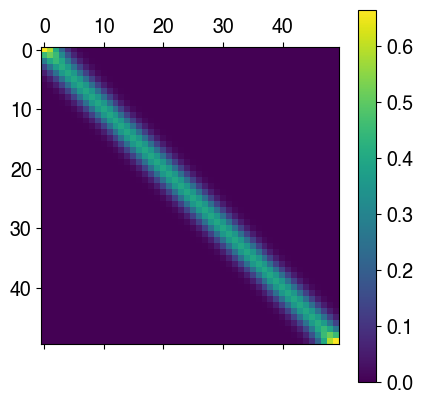

In [44]:
# original gaussian symmetric interaction matrix
plt.matshow(net.edge_Jmat)
plt.colorbar()

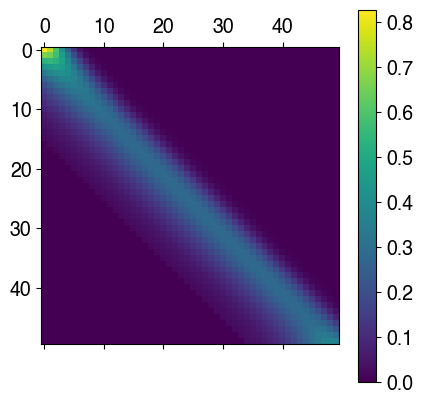

In [73]:
# "desired bump rates" interaction matrix
plt.matshow(net.edge_Jmat)
plt.colorbar()

In [7]:
# run simulation

noise_var = 1e-6 #1e-4 (1e-4 used for 231117 plots) # 0.1 # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0 + 2**(i_final-1)
delta_t = 0.001 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net.find_edge_state(n_0)
    
# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final-t_0,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_0
rates = states2rates(states)

In [8]:
def nice_neuron_xlabels(Npopulation):
    labels=['' for i in range(Npopulation)]
    labeled_n = [0,int(Npopulation/2),Npopulation-1]
    for n in labeled_n:
        labels[n] = n
    plt.xticks(ticks=range(Npopulation),labels=labels)
    defaultFigure.makePretty()

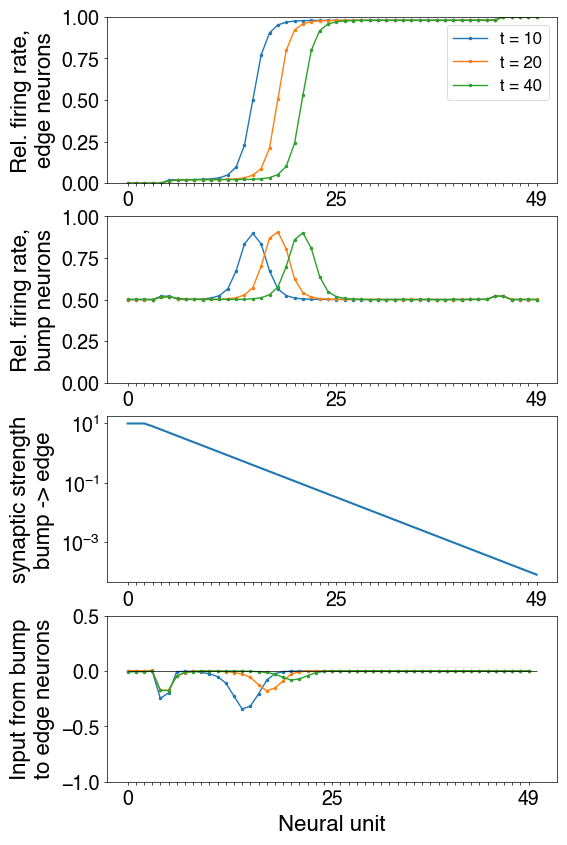

In [9]:
plt.figure(figsize=(6,9))
minInput,maxInput = 0,4
minRate,maxRate = 0,1 #-1,1
#times = [1,2,4,8,16,32] 
times = [10,20,40]

# firing rate plot, edge neurons
plt.subplot(4,1,1)
for t in times:
    plt.plot(rates.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nedge neurons')
nice_neuron_xlabels(net.Npopulation)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minRate,ymax=maxRate)

# firing rate plot, bump neurons
plt.subplot(4,1,2)
for t in times:
    plt.plot(rates.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
#plt.hlines(0,0,50,color='k',lw=0.5)   
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nbump neurons')
nice_neuron_xlabels(net.Npopulation)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
plt.axis(ymin=minRate,ymax=maxRate)

# interaction strength from bump to edge neurons
plt.subplot(4,1,3)
plt.plot(-np.array(J_bump_edge))
plt.ylabel('synaptic strength\nbump -> edge')
#plt.xlabel('Neural unit')
plt.yscale('log')
nice_neuron_xlabels(net.Npopulation)

# input from bump neurons to edge neurons
plt.subplot(4,1,4)
for t in times:
    if np.shape(net.sigma) == (net.Ntotal,net.Ntotal):
        #activities = [ np.tanh(np.tile(np.array(states.loc[i]),(net.Ntotal,1))/net.sigma) for i in states.index ]
        #bumpActivities = np.array(activities)[Npopulation:2*Npopulation-1]
        print("Haven't figured out plotting bump->edge neuron input for non-constant sigma yet")
    else:
        activities = np.tanh(states/net.sigma)
        bumpActivities = activities.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)]
        bump_to_edge_input = np.dot(bumpActivities,net.bump_edge_Jmat)
        plt.plot(bump_to_edge_input,'.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Input from bump\nto edge neurons')
nice_neuron_xlabels(net.Npopulation)
plt.axis(ymin=-1,ymax=+0.5)


plt.subplots_adjust(bottom=0.1,top=0.95,left=0.2,right=0.95)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

(9.047704625349029, 81.78870007833102, 15.0, 24.0)

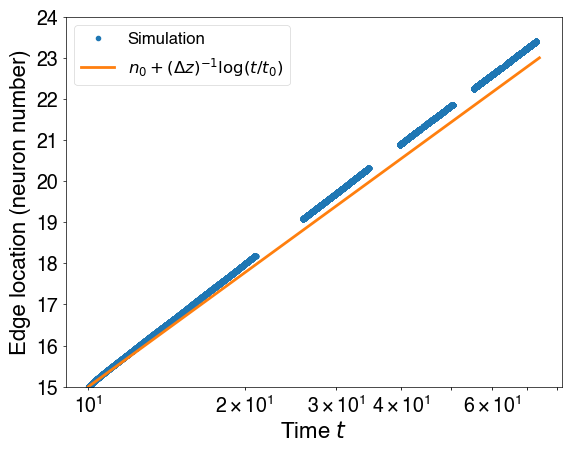

In [38]:
# plot edge location versus time
# 2024/1/26 (NOTE: With our new states function, we need to shift since find_edge_location looks for a zero crossing)
plt.plot(states.index,[find_edge_location(states.loc[i])[0] for i in states.index],'.',label='Simulation')
plt.plot(states.index,n_0+1./delta_z*np.log(states.index/t_0),
         label='$n_0+ (\Delta z)^{-1}\log(t/t_0)$',lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Edge location (neuron number)')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
#plt.savefig('231117_self_sustained_edge_location_vs_time.pdf')
plt.axis(ymin=n_0)
plt.xscale('log')
plt.axis(ymax=24)

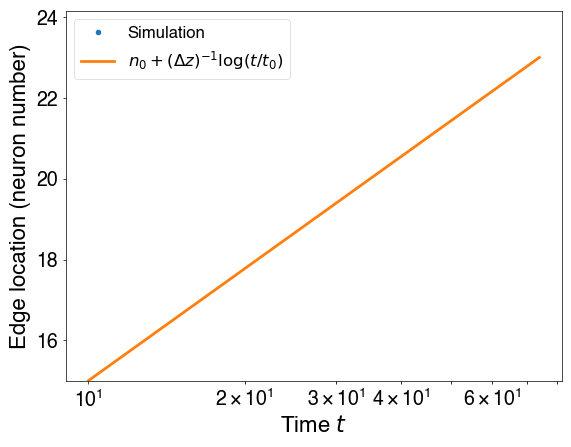

In [36]:
# plot edge location versus time
plt.plot(rates.index,[find_edge_location(rates.loc[i])[0] for i in rates.index],'.',label='Simulation')
plt.plot(rates.index,n_0+1./delta_z*np.log(rates.index/t_0),
         label='$n_0+ (\Delta z)^{-1}\log(t/t_0)$',lw=2)
plt.xlabel('Time $t$')
plt.ylabel('Edge location (neuron number)')
leg = plt.legend()
defaultFigure.makePretty(leg=leg)
#plt.savefig('231117_self_sustained_edge_location_vs_time.pdf')
plt.axis(ymin=n_0)
plt.xscale('log')

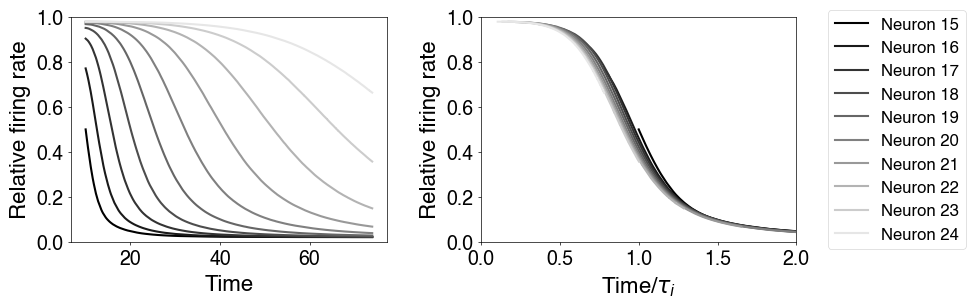

In [11]:
plt.figure(figsize=(10,3))

# plot rate over time for particular neurons
plt.subplot(1,2,1)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(rates[name],label=name,
             color=str((neuron_index-n_0)/10))
leg = plt.legend(loc=(2.4,-0.03))
plt.xlabel('Time')
plt.ylabel('Relative firing rate')
plt.axis(ymin=0,ymax=1)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.savefig('231018_firing_rate_vs_time.pdf')

# plot rate over time for particular neurons, rescaled in time
plt.subplot(1,2,2)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    times = rates[name].index
    tau = t_0*np.exp((neuron_index-n_0)*delta_z)
    plt.plot(times/tau,rates[name],label=name,
             color=str((neuron_index-n_0)/10))
#leg = plt.legend()
plt.xlabel('Time/$\\tau_i$')
plt.ylabel('Relative firing rate')
plt.axis(ymin=0,ymax=1,xmin=0,xmax=2)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.yscale('log')

plt.subplots_adjust(wspace=0.3,bottom=0.2,top=0.95,left=0.1,right=0.825)
plt.savefig('240118_firing_rate_vs_time.pdf')

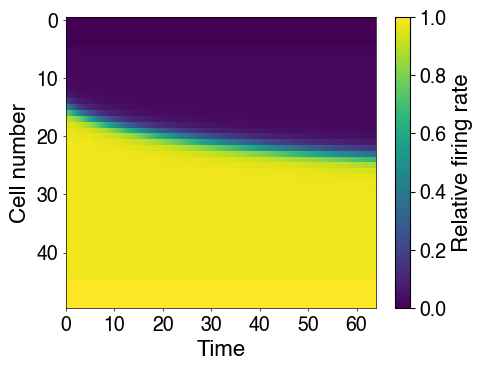

In [115]:
# 2024/1/18 make 2D heat-map plot
fig = plt.figure(figsize=(5,5))
plt.matshow(rates.T[:Npopulation],fignum=fig)
plt.gca().set_aspect(1200)
plt.gca().xaxis.tick_bottom()
plt.xticks(range(0,70000,10000),range(0,70,10))
plt.xlabel('Time')
plt.ylabel('Cell number')
plt.colorbar(shrink=0.75,label='Relative firing rate')
#fig.subplots_adjust(bottom=0.2,top=0.95) # doesn't do anything?
defaultFigure.makePretty()
plt.savefig('240118_edge_neuron_firing_rate_vs_cell_and_time.pdf')

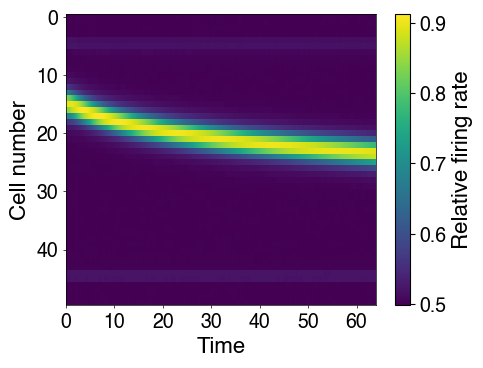

In [114]:
# 2024/1/18 make 2D heat-map plot
fig = plt.figure(figsize=(5,5))
plt.matshow(rates.T[Npopulation:],fignum=fig)
plt.gca().set_aspect(1200)
plt.gca().xaxis.tick_bottom()
plt.xticks(range(0,70000,10000),range(0,70,10))
plt.xlabel('Time')
plt.ylabel('Cell number')
plt.colorbar(shrink=0.75,label='Relative firing rate')
#fig.subplots_adjust(bottom=0.2,top=0.95) # doesn't do anything?
defaultFigure.makePretty()
plt.savefig('240118_bump_neuron_firing_rate_vs_cell_and_time.pdf')

# 2024/1/2 What would exact exponential decay look like?

In [14]:
def desiredEdgeStates(n,t,minval=-25):
    return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))

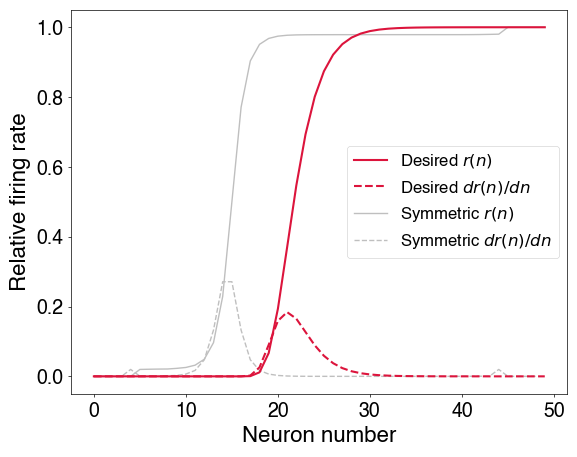

In [51]:
nList = np.arange(0,Npopulation)
t = 20 #1 #20
plt.plot(nList,desiredEdgeRates(nList,t,delta_z=1/2),
         label='Desired $r(n)$',
         color='crimson')
plt.plot(nList,desiredBumpRates(nList,t,delta_z=1/2),
         label='Desired $dr(n)/dn$',
         color='crimson',ls='--')
# compare to our existing simulation that uses simple gaussian interaction kernel
plt.plot(states2rates(edge_state[:Npopulation]),
         label='Symmetric $r(n)$',
         color='0.75',lw=1,zorder=-10)
#plt.plot(states2rates(edge_state[Npopulation:]))
plt.plot(states2rates(edge_state[1:Npopulation])-states2rates(edge_state[:Npopulation-1]),
         label='Symmetric $dr(n)/dn$',
         color='0.75',ls='--',lw=1,zorder=-10)
leg = plt.legend()
plt.xlabel('Neuron number')
plt.ylabel('Relative firing rate')
defaultFigure.makePretty(leg=leg)
plt.subplots_adjust(bottom=0.15,top=0.95)
plt.savefig('240118_desired_edge_shape.pdf')

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


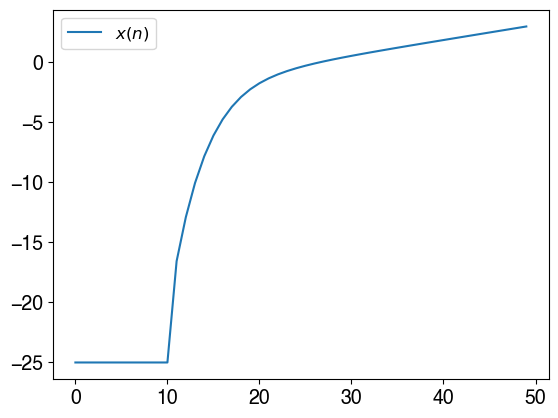

In [501]:
nList = np.arange(0,Npopulation)
t = 1 #20
plt.plot(nList,desiredEdgeStates(nList,t),label='$x(n)$')
plt.legend()

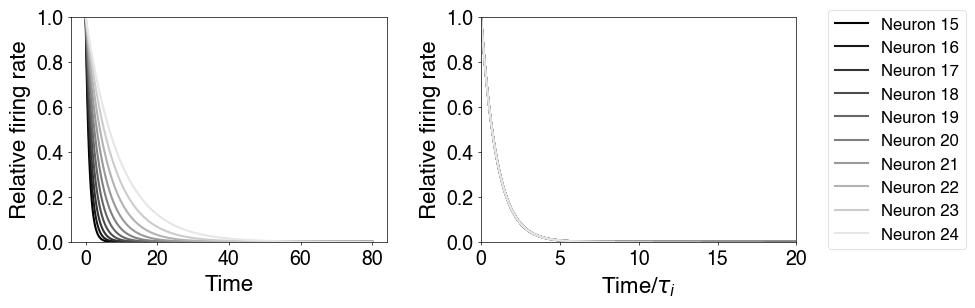

In [52]:
# make plot similar to above simulation plots to show exact rescaling

plt.figure(figsize=(10,3))

t_max = 80 #10 #80

# plot rate over time for particular neurons
plt.subplot(1,2,1)
neuron_indices = range(n_0,n_0+10)
times = np.linspace(0,t_max,1000)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(times,desiredEdgeRates(neuron_index,times),label=name,
             color=str((neuron_index-n_0)/10))
leg = plt.legend(loc=(2.4,-0.03))
plt.xlabel('Time')
plt.ylabel('Relative firing rate')
plt.axis(ymin=0,ymax=1)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.savefig('231018_firing_rate_vs_time.pdf')

# plot rate over time for particular neurons, rescaled in time
plt.subplot(1,2,2)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    tau = np.exp((neuron_index-n_0)*delta_z)
    plt.plot(times/tau,desiredEdgeRates(neuron_index,times),label=name,
             color=str((neuron_index-n_0)/10))
#leg = plt.legend()
plt.xlabel('Time/$\\tau_i$')
plt.ylabel('Relative firing rate')
plt.axis(ymin=0,ymax=1,xmin=1e-10,xmax=20)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
#plt.yscale('log')

plt.subplots_adjust(wspace=0.3,bottom=0.2,top=0.95,left=0.1,right=0.825)
plt.savefig('240118_desired_firing_rate_vs_time.pdf')

# 2024/1/3 Find interaction kernel that gives the desired edge shape

In [740]:
print(interactionMatrixFromKernel([0.05,0.1,1,0.1,0.05],5))

[[0.86956522 0.08695652 0.04347826 0.         0.        ]
 [0.08       0.8        0.08       0.04       0.        ]
 [0.03846154 0.07692308 0.76923077 0.07692308 0.03846154]
 [0.         0.04       0.08       0.8        0.08      ]
 [0.         0.         0.04347826 0.08695652 0.86956522]]


In [302]:
# check that this approach gives the same matrix as the laplace_network when the
# kernel is gaussian
import scipy.stats
Jmat = net.J*interactionMatrixFromKernel(
    scipy.stats.distributions.norm.pdf(range(49),loc=24,scale=net.kernel_width),net.Npopulation)
print(Jmat[:10,0])

print(net.Jmat_no_feedback[:10,0])

[6.65196964e-01 4.53827975e-01 2.69829667e-01 1.34701951e-01
 5.46186508e-02 1.75762480e-02 4.43411890e-03 8.72748769e-04
 1.33831402e-04 1.59837539e-05]
[6.65196964e-01 4.53827975e-01 2.69829667e-01 1.34701951e-01
 5.46186508e-02 1.75762480e-02 4.43411890e-03 8.72748769e-04
 1.33831402e-04 1.59837539e-05]


In [303]:
from simpleNeuralModel import findFixedPoint
#from laplace_network import gaussian_kernel_matrix
import scipy.optimize as opt

In [69]:
initialGuessState_edge = (np.arange(0,net.Npopulation)-n_0)/net.kernel_width

In [71]:
edge = findFixedPoint(Jmat,initialGuessState_edge)

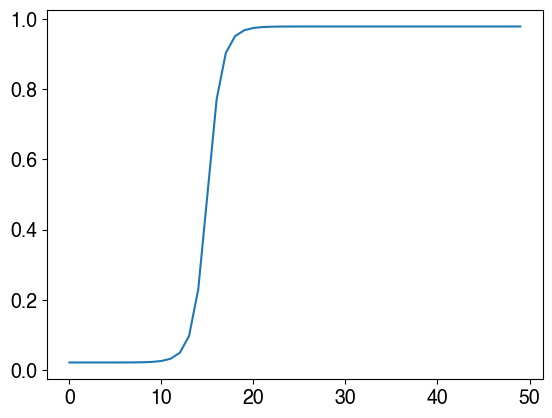

In [74]:
plt.plot(0.5*(1+np.tanh(edge)))

In [524]:
def findBestKernel(desiredRates,initialKernel,initialWidth=1,inputExt=0,initialInteractionScale=1):
    """
    Note: N must be even.  This restriction might be something we could remove in the future.  
    See interactionMatrixFromKernel.
    
    desiredRates              : length N
    initialKernel             : length N-1
    """
    N = len(desiredRates)
    assert(len(initialKernel) == N-1)
    
    # the kernel degrees of freedom consist of an overall scale factor plus a vector of length N-1
    initialKernelAndScale = np.concatenate([[initialInteractionScale,],initialKernel])
    
    # start from initial state with width initialWidth and location N/2
    n_0 = N/2
    initialGuessState_edge = (np.arange(0,N)-n_0)/initialWidth
    initialGuessState_exp = [ desiredEdgeStates(i,1) for i in range(N) ]
    initialGuessState = initialGuessState_edge
    
    # define function to be minimized and minimize it
    # (JW = [J,W], where J is a number corresponding to an overall scale factor and W is a length N-1 vector)
    if False: # root method
        deltaRates = lambda JW: states2rates(
                                findFixedPoint(JW[0]*interactionMatrixFromKernel(JW[1:],N),
                                               initialGuessState,
                                               inputExt=inputExt)) - desiredRates
        sol = opt.root(deltaRates,initialKernelAndScale,method='lm')#,options={'factor':100})
    else: # minimize sum of squares naively
        delta = lambda JW: np.sum( (states2rates(
                                findFixedPoint(JW[0]*interactionMatrixFromKernel(JW[1:],N),
                                               initialGuessState,
                                               inputExt=inputExt)) - desiredRates)**2 )
        sol = opt.minimize(delta,initialKernelAndScale)
    
    return sol,sol.x

In [525]:
findBestKernel([0.,0.1,0.2,1,0.2,0.9,],[0.,0.1,0.2,1,0.2,])

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


(  message: Desired error not necessarily achieved due to precision loss.
   success: False
    status: 2
       fun: 0.9400047762108751
         x: [ 1.013e+00 -5.878e-03  1.324e-01  2.632e-01  1.012e+00
              2.616e-01]
       nit: 5
       jac: [-3.861e-02  0.000e+00 -7.451e-09 -7.451e-09  0.000e+00
              0.000e+00]
  hess_inv: [[ 6.298e-03 -3.701e-02 ...  7.355e-02  3.880e-01]
             [-3.701e-02  1.218e+00 ... -4.322e-01 -2.280e+00]
             ...
             [ 7.355e-02 -4.322e-01 ...  1.859e+00  4.530e+00]
             [ 3.880e-01 -2.280e+00 ...  4.530e+00  2.490e+01]]
      nfev: 434
      njev: 61,
 array([ 1.01341414, -0.00587818,  0.13235138,  0.26324371,  1.01167624,
         0.26159961]))

In [526]:
N = net.Npopulation
width = net.kernel_width
initialKernel = scipy.stats.distributions.norm.pdf(range(49),loc=24,scale=net.kernel_width)

In [527]:
# first test to see if we can recover something vaguely gaussian if we want a symmetric edge
n_0 = net.Npopulation/2
initialStates_edge = (np.arange(0,net.Npopulation)-n_0)/net.kernel_width
desiredRatesEdge = states2rates(initialStates_edge)
inputExt = net.inputExt

sol,k_opt_gaussian = findBestKernel(desiredRatesEdge,initialKernel,inputExt=inputExt[:50],
                                   initialInteractionScale=3.)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


In [528]:
sol

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.0007404892569052291
        x: [ 3.069e+00  2.610e-02 ...  1.765e-02  4.939e-02]
      nit: 48
      jac: [-1.387e-03  9.567e-02 ... -9.091e-02 -6.658e-02]
 hess_inv: [[ 1.493e+01  1.069e+01 ...  1.884e-01 -5.371e+00]
            [ 1.069e+01  8.731e+00 ...  9.513e-02 -4.363e+00]
            ...
            [ 1.884e-01  9.513e-02 ...  7.355e-01 -3.774e-01]
            [-5.371e+00 -4.363e+00 ... -3.774e-01  2.417e+00]]
     nfev: 21730
     njev: 426

In [529]:
k_opt_gaussian[0]

3.0690505982814646

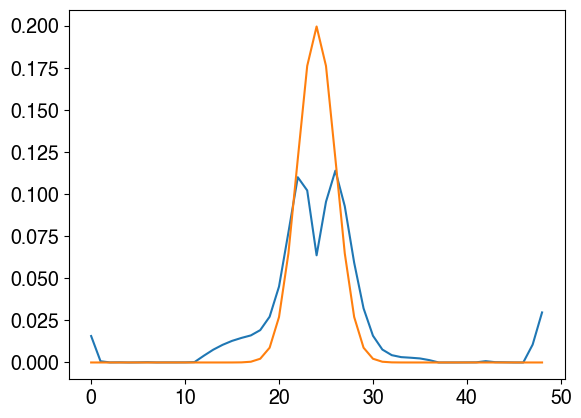

In [530]:
plt.plot(abs(k_opt_gaussian[1:])/np.sum(abs(k_opt_gaussian[1:])))
plt.plot(initialKernel)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


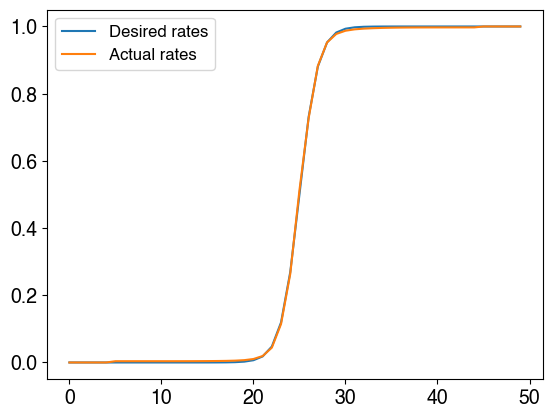

In [531]:
# check the resultant rates
initialStates_exp = [ desiredEdgeStates(i,1) for i in range(N) ]
actual_rates = states2rates(findFixedPoint(
    k_opt_gaussian[0]*interactionMatrixFromKernel(k_opt_gaussian[1:],net.Npopulation),
                                               initialStates_exp,
                                               inputExt=net.inputExt[:net.Npopulation]))
plt.plot(desiredRatesEdge,label='Desired rates')
plt.plot(actual_rates,label='Actual rates')
plt.legend()

In [ ]:
# TO DO: Fix n_0 input to desiredEdgeRates

In [532]:
# now try to fit the "exponential" shape that we really want

n_0 = net.Npopulation/2
desiredRatesExp = [ desiredEdgeRates(i,1) for i in range(net.Npopulation) ]
inputExt = net.inputExt

sol,k_opt_exp = findBestKernel(desiredRatesExp,initialKernel,inputExt=inputExt[:50],
                                   initialInteractionScale=3.) #3.)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


In [520]:
sol

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.5798296506950847
        x: [ 2.969e+00 -1.234e-02 ...  8.202e-04 -8.633e-04]
      nit: 6
      jac: [ 7.057e+02  1.773e+03 ...  1.944e+02  3.668e+02]
 hess_inv: [[ 5.767e+00  1.132e+01 ... -8.803e-01 -3.235e+00]
            [ 1.132e+01  2.621e+01 ... -1.963e+00 -7.250e+00]
            ...
            [-8.803e-01 -1.963e+00 ...  1.143e+00  5.600e-01]
            [-3.235e+00 -7.250e+00 ...  5.600e-01  3.046e+00]]
     nfev: 3480
     njev: 68

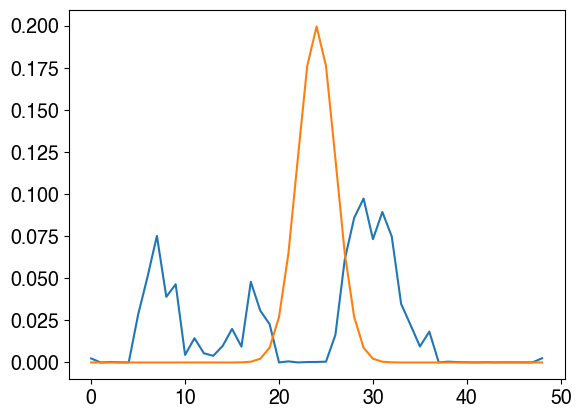

In [533]:
plt.plot(abs(k_opt_exp[1:])/np.sum(abs(k_opt_exp[1:])))
plt.plot(initialKernel)

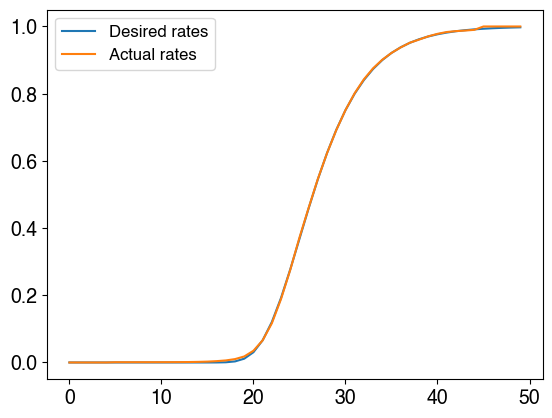

In [535]:
# check the resultant rates
fitInteractionMatrix = k_opt_exp[0]*interactionMatrixFromKernel(k_opt_exp[1:],net.Npopulation)
actual_rates_exp = states2rates(findFixedPoint(
                                   fitInteractionMatrix,
                                   initialStates_edge,
                                   inputExt=net.inputExt[:net.Npopulation]))
plt.plot(desiredRatesExp,label='Desired rates')
plt.plot(actual_rates_exp,label='Actual rates')
plt.legend()

# 2024/1/5 try other kernel shapes

In [745]:
# skew normal
scale = 1*net.kernel_width # 4*
a = 0 #-100 #-5
offset = scipy.stats.distributions.skewnorm.ppf(0.5,scale=scale,a=a)
skewKernel = scipy.stats.distributions.skewnorm.pdf(range(49),loc=24-offset,scale=scale,a=a)

In [885]:
# two gaussians, symmetric around 0, with different heights
scale = 1*net.kernel_width
separation = 10
height_factor = 2
scale_factor = 2.
offset_double = 1
gaussianRight = scipy.stats.distributions.norm.pdf(range(49),
                                                   loc=24+separation/2+offset_double,
                                                   scale=scale)
gaussianLeft = scipy.stats.distributions.norm.pdf(range(49),
                                                   loc=24-separation/2+offset_double,
                                                   scale=scale*scale_factor)
doubleGaussianKernel = gaussianRight + height_factor*gaussianLeft

In [892]:
def doubleGaussianK(N,scale,separation,height_factor,scale_factor,offset_double):
    gaussianRight = scipy.stats.distributions.norm.pdf(range(N-1),
                                                   loc=N/2-1+separation/2+offset_double,
                                                   scale=scale)
    gaussianLeft = scipy.stats.distributions.norm.pdf(range(N-1),
                                                   loc=N/2-1-separation/2+offset_double,
                                                   scale=scale*scale_factor)
    return gaussianRight + height_factor*gaussianLeft

In [896]:
def findBestDoubleGaussianKernel(desiredRates,initialPrefactor=3.,initialScale=1,initialSeparation=10,
                                 initialHeightFactor=2,initialScaleFactor=2,initialOffset=1,
                                 inputExt=0):
    """
    desiredRates              : length N
    initialKernel             : length N-1
    """
    N = len(desiredRates)
    assert(len(initialKernel) == N-1)
    
    # the kernel degrees of freedom consist of an overall scale factor plus 5 parameters
    initialParams = [initialPrefactor,initialScale,initialSeparation,initialHeightFactor,
                     initialScaleFactor,initialOffset]
    
    # start from initial state with width initialScale and location N/2
    n_0 = N/2
    initialGuessState_edge = (np.arange(0,N)-n_0)/initialScale
    # or from initial exponential edge shape
    initialGuessState_exp = [ desiredEdgeStates(i,1) for i in range(N) ]
    initialGuessState = initialGuessState_exp
    
    # define function to be minimized and minimize it
    # (minimize sum of squares naively)
    delta = lambda params: np.sum( (states2rates(
                                findFixedPoint(params[0]*interactionMatrixFromKernel(
                                        doubleGaussianK(N,params[1],params[2],
                                                        params[3],params[4],params[5]),N),
                                               initialGuessState,
                                               inputExt=inputExt)) - desiredRates)**2 )
    sol = opt.minimize(delta,initialParams)
    
    return sol,sol.x

In [907]:
n_0 = net.Npopulation/2
desiredRatesExp = [ desiredEdgeRates(i,1) for i in range(net.Npopulation) ]
inputExt = net.inputExt

sol,k_opt_double_gaussian_exp = findBestDoubleGaussianKernel(desiredRatesExp,inputExt=inputExt[:50],
                                   initialPrefactor=2.) #3.)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3482488473.py:2: RuntimeWarning: divide by zero encountered in arctanh
  return np.maximum(minval,np.arctanh(-1+2*desiredEdgeRates(n,t)))


In [908]:
sol

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.025755818709899504
        x: [ 2.003e+00  1.006e+00  1.000e+01  2.007e+00  2.005e+00
             1.003e+00]
      nit: 3
      jac: [ 1.125e+02  1.437e+02  4.985e+01  6.222e+01  1.356e+02
            -4.453e+01]
 hess_inv: [[ 6.043e-01 -1.076e-03 ...  2.060e-01  2.069e-01]
            [-1.076e-03  6.844e-01 ... -3.958e-01  8.341e-02]
            ...
            [ 2.060e-01 -3.958e-01 ...  3.739e-01  1.411e-01]
            [ 2.069e-01  8.341e-02 ...  1.411e-01  2.692e-01]]
     nfev: 236
     njev: 32

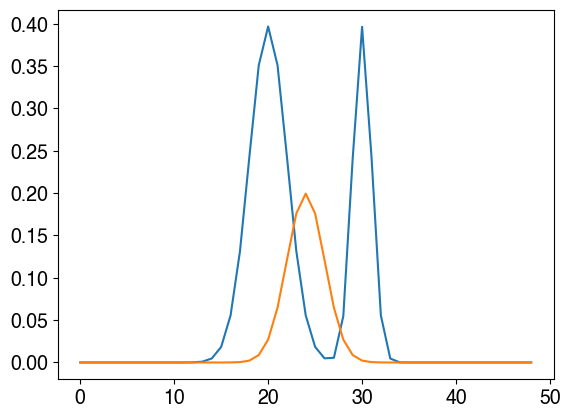

In [919]:
params = k_opt_double_gaussian_exp
fitDoubleGaussian = doubleGaussianK(N,params[1],params[2],
                                params[3],params[4],params[5])
plt.plot(fitDoubleGaussian)
plt.plot(initialKernel)

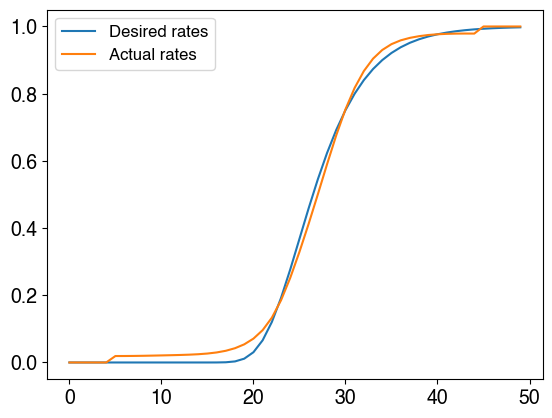

In [935]:
# check the resultant rates
params = k_opt_double_gaussian_exp
fitDoubleGaussian = doubleGaussianK(net.Npopulation,params[1],params[2],
                                params[3],params[4],params[5])
fitDoubleGaussianInteractionMatrix = params[0]*interactionMatrixFromKernel(fitDoubleGaussian,net.Npopulation)
actual_rates_exp = states2rates(findFixedPoint(
                                   fitDoubleGaussianInteractionMatrix,
                                   initialStates_exp,
                                   inputExt=net.inputExt[:net.Npopulation]))
plt.plot(desiredRatesExp,label='Desired rates')
plt.plot(actual_rates_exp,label='Actual rates')
plt.legend()

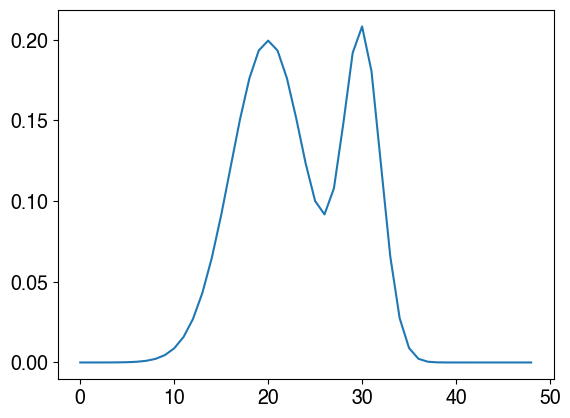

In [886]:
plt.plot(doubleGaussianKernel)

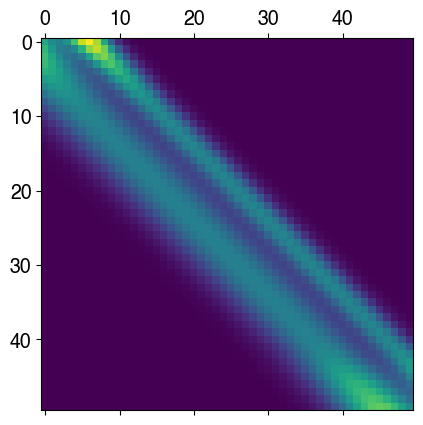

In [887]:
skewPrefactor = 2.
skewInteractionMatrix = skewPrefactor*interactionMatrixFromKernel(skewKernel,net.Npopulation,n_decay=-50)

doubleGaussianPrefactor = 3.
doubleGaussianInteractionMatrix = doubleGaussianPrefactor*interactionMatrixFromKernel(doubleGaussianKernel,
                                                                                      net.Npopulation)
plt.matshow(doubleGaussianInteractionMatrix)

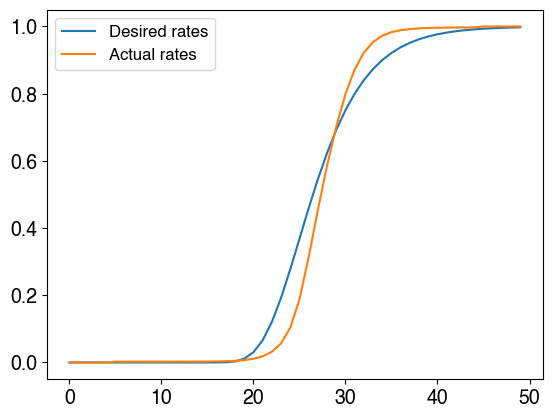

In [931]:
# check the resultant rates
actual_rates_skew = states2rates(findFixedPoint(
                                   doubleGaussianInteractionMatrix,
                                   initialStates_edge,
                                   inputExt=net.inputExt[:net.Npopulation]))
plt.plot(desiredRatesExp,label='Desired rates')
plt.plot(actual_rates_skew,label='Actual rates')
plt.legend()

# 2024/1/3 simulate a system with the fit kernel

In [928]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 50 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #0.5 #1 
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0 = 1. #10. #1. (1. used for 231117 plots) #0.1 #0.5 
n_0 = 25 #15 # 25 (25 used for 231117 plots)
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor = 0. #1 #2 #0.1 #0.5 #0.9 (0.9 used for 231117 plots)
J_bump_edge = [ -J_bump_edge_scale_factor*min(1./t_0*1./delta_z*np.exp(-delta_z*(n-n_0)),
                                              J_bump_edge_max) for n in range(Npopulation) ]
kernel_width = 2 #1 # 0.1 # (set to default 2 for 231117 plots)

net_exp = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width)

# 2024/1/3 replace interaction matrix with fit "exponential" version
#net_exp.Jmat[:Npopulation,:Npopulation] = fitInteractionMatrix
#net_exp.Jmat_no_feedback[:Npopulation,:Npopulation] = fitInteractionMatrix

# 2024/1/5 replace interaction matrix with "double Gaussian" version fit roughly by eye
# net_exp.Jmat[:Npopulation,:Npopulation] = doubleGaussianInteractionMatrix
# net_exp.Jmat_no_feedback[:Npopulation,:Npopulation] = doubleGaussianInteractionMatrix

# 2024/1/5 replace interaction matrix with "double Gaussian" version fit numerically
net_exp.Jmat[:Npopulation,:Npopulation] = fitDoubleGaussianInteractionMatrix
net_exp.Jmat_no_feedback[:Npopulation,:Npopulation] = fitDoubleGaussianInteractionMatrix

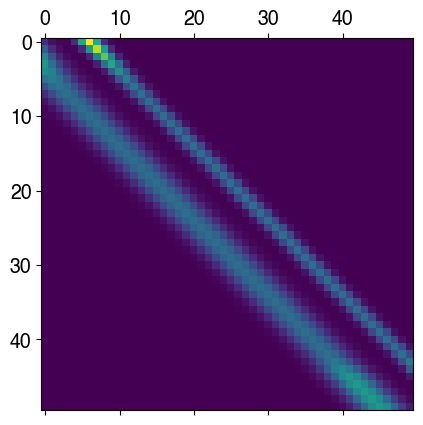

In [917]:
plt.matshow(fitDoubleGaussianInteractionMatrix)

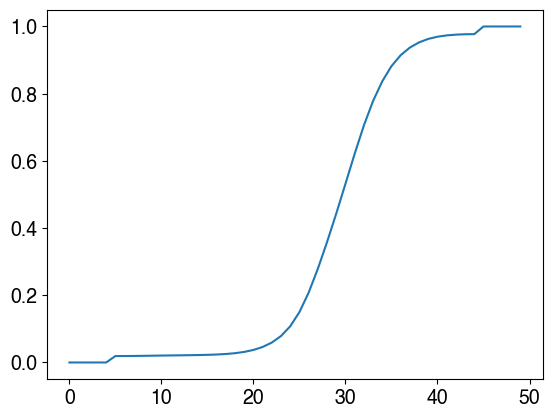

In [937]:
# starting state
edge_state = net_exp.find_edge_state(n_0,method='minimize')
plt.plot(states2rates(edge_state)[:net_exp.Npopulation])

In [923]:
len(initialStates_exp)

50

In [938]:
# run simulation

noise_var = 1e-6 #1e-4 (1e-4 used for 231117 plots) # 0.1 # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0 + 2**(i_final-1)
delta_t = 0.001 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_exp.find_edge_state(n_0,method='minimize')
# or use initial desired "exponential" edge shape initialStates_exp (currently with zeros for bump neurons)
exp_state = np.concatenate([initialStates_exp,np.zeros(net_exp.Npopulation)])
    
# simulate dynamics
states = net_exp.simulate_dynamics(edge_state,
                               t_final-t_0,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states.index = states.index + t_0
rates = states2rates(states)

/var/folders/2y/r9yfmnys37xd00fknrv2tgym0000gn/T/ipykernel_5275/3609739690.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


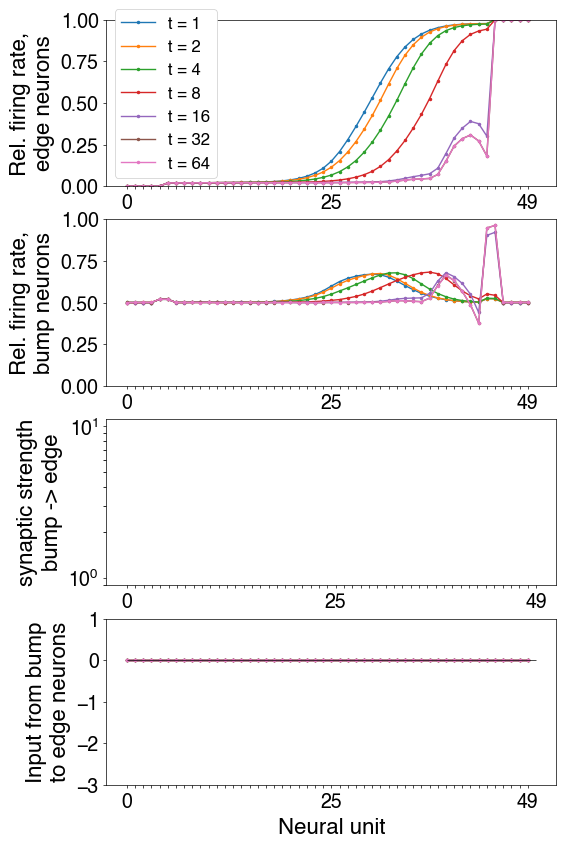

In [939]:
plt.figure(figsize=(6,9))
minInput,maxInput = 0,4
minRate,maxRate = 0,1
times = [1,2,4,8,16,32,64] 
#times = [10,20,40]

# firing rate plot, edge neurons
plt.subplot(4,1,1)
for t in times:
    plt.plot(rates.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nedge neurons')
nice_neuron_xlabels(net_exp.Npopulation)
leg = plt.legend(framealpha=1)
defaultFigure.makePretty(leg=leg)
plt.axis(ymin=minRate,ymax=maxRate)

# firing rate plot, bump neurons
plt.subplot(4,1,2)
for t in times:
    plt.plot(rates.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)],
             '.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
#plt.xlabel('Neural unit')
plt.ylabel('Rel. firing rate,\nbump neurons')
nice_neuron_xlabels(net_exp.Npopulation)
#leg = plt.legend(framealpha=1)
defaultFigure.makePretty()
plt.axis(ymin=minRate,ymax=maxRate)

# interaction strength from bump to edge neurons
plt.subplot(4,1,3)
plt.plot(-np.array(J_bump_edge))
plt.ylabel('synaptic strength\nbump -> edge')
#plt.xlabel('Neural unit')
plt.yscale('log')
nice_neuron_xlabels(net_exp.Npopulation)

# input from bump neurons to edge neurons
plt.subplot(4,1,4)
for t in times:
    activities = np.tanh(states)
    edgeActivities = activities.loc[t]['Neuron {}'.format(Npopulation):'Neuron {}'.format(2*Npopulation-1)]
    bump_to_edge_input = np.dot(edgeActivities,net.bump_edge_Jmat)
    plt.plot(bump_to_edge_input,'.-',label="t = {}".format(t),lw=1,ms=3)
plt.hlines(0,0,50,color='k',lw=0.5)   
plt.xlabel('Neural unit')
plt.ylabel('Input from bump\nto edge neurons')
nice_neuron_xlabels(net.Npopulation)
plt.axis(ymin=-1,ymax=+0.5)


plt.subplots_adjust(bottom=0.1,top=0.95,left=0.2,right=0.95)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

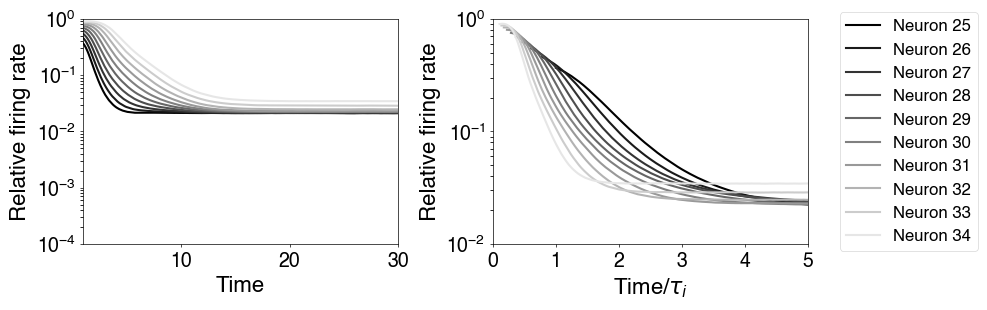

In [927]:
plt.figure(figsize=(10,3))
tMin,tMax = 1,30

# plot rate over time for particular neurons
plt.subplot(1,2,1)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    plt.plot(rates[name],label=name,
             color=str((neuron_index-n_0)/10))
leg = plt.legend(loc=(2.4,-0.03))
plt.xlabel('Time')
plt.ylabel('Relative firing rate')
plt.axis(ymin=1e-4,ymax=1,xmin=tMin,xmax=tMax)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
plt.yscale('log')
#plt.savefig('231018_firing_rate_vs_time.pdf')

# plot rate over time for particular neurons, rescaled in time
plt.subplot(1,2,2)
neuron_indices = range(n_0,n_0+10)
for neuron_index in neuron_indices:
    name = 'Neuron {}'.format(neuron_index)
    times = rates[name].index
    tau = np.exp((neuron_index-n_0)*delta_z)
    plt.plot(times/tau,rates[name],label=name,
             color=str((neuron_index-n_0)/10))
#leg = plt.legend()
plt.xlabel('Time/$\\tau_i$')
plt.ylabel('Relative firing rate')
plt.axis(ymin=1e-2,ymax=1,xmin=0,xmax=5)
plt.subplots_adjust(left=0.15,right=0.95)
defaultFigure.makePretty(leg=leg)
plt.yscale('log')

plt.subplots_adjust(wspace=0.3,bottom=0.2,top=0.95,left=0.1,right=0.825)
#plt.savefig('231215_firing_rate_vs_time.pdf')